In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [4]:
dsets.train[0]

(fname       007437.jpg
 labels             bus
 is_valid         False
 Name: 3749, dtype: object,
 fname       007437.jpg
 labels             bus
 is_valid         False
 Name: 3749, dtype: object)

In [5]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x= get_x, get_y= get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/explore/.fastai/data/pascal_2007/train/007216.jpg'),
 ['horse', 'person'])

In [6]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x= get_x, get_y= get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

In [7]:
idxs=torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['person']

In [8]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                   get_x = get_x, get_y = get_y
                  
                  )
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [9]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                   get_x = get_x, get_y = get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35)
                  
                  )
dls = dblock.dataloaders(df)

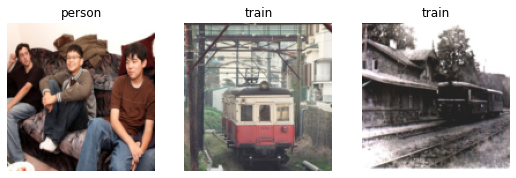

In [10]:
dls.show_batch(nrows=1, ncols=3)

In [11]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /home/explore/.fastai/data/pascal_2007/tra

In [12]:
learn = cnn_learner(dls, resnet18)

In [13]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [14]:
activs[0]

tensor([ 3.0564,  0.1838,  3.9815,  0.2757,  0.4892, -1.0874, -0.8191, -0.1506,
        -1.1775,  0.0513, -2.8702,  0.1371,  2.2596,  0.3396, -0.2656,  2.2631,
         3.0607,  2.6313,  5.3056,  4.1861], grad_fn=<SelectBackward>)

In [15]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [16]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0950, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [17]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [18]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947961,0.713911,0.227351,00:10
1,0.821796,0.557045,0.290558,00:08
2,0.605401,0.204198,0.808446,00:08
3,0.362325,0.124442,0.940717,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131685,0.113289,0.945379,00:11
1,0.117510,0.109186,0.951394,00:10
2,0.096323,0.103828,0.950259,00:10


In [19]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10382768511772156,0.9273306131362915]

In [20]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10382768511772156,0.943207323551178]

In [23]:
preds, targs = learn.get_preds()

In [24]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9571)

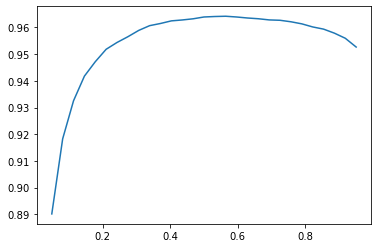

In [25]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

# regression

In [26]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [27]:
path.ls()

(#50) [Path('/home/explore/.fastai/data/biwi_head_pose/13'),Path('/home/explore/.fastai/data/biwi_head_pose/07.obj'),Path('/home/explore/.fastai/data/biwi_head_pose/02'),Path('/home/explore/.fastai/data/biwi_head_pose/16'),Path('/home/explore/.fastai/data/biwi_head_pose/06'),Path('/home/explore/.fastai/data/biwi_head_pose/15'),Path('/home/explore/.fastai/data/biwi_head_pose/08'),Path('/home/explore/.fastai/data/biwi_head_pose/02.obj'),Path('/home/explore/.fastai/data/biwi_head_pose/10.obj'),Path('/home/explore/.fastai/data/biwi_head_pose/03.obj')...]

In [28]:
(path/'01').ls()

(#1000) [Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00439_rgb.jpg'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00230_rgb.jpg'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00105_pose.txt'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00431_rgb.jpg'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00474_pose.txt'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00022_pose.txt'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00439_pose.txt'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00042_rgb.jpg'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00073_rgb.jpg'),Path('/home/explore/.fastai/data/biwi_head_pose/01/frame_00055_pose.txt')...]

In [29]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])


Path('/home/explore/.fastai/data/biwi_head_pose/13/frame_00439_pose.txt')

In [30]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

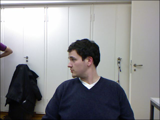

In [31]:
im.to_thumb(160)

In [32]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [33]:
get_ctr(img_files[0])

tensor([310.6393, 248.3094])

In [34]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

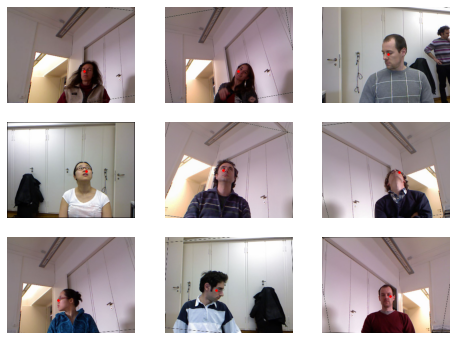

In [35]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [36]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [37]:
yb[0]

tensor([[-0.0666,  0.2552]], device='cuda:0')

### Training a Model

As usual, we can use `cnn_learner` to create our `Learner`. Remember way back in <<chapter_intro>> how we used `y_range` to tell fastai the range of our targets? We'll do the same here (coordinates in fastai and PyTorch are always rescaled between -1 and +1):

In [38]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented in fastai using `sigmoid_range`, which is defined as:

In [50]:
from fastbook import *
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

This is set as the final layer of the model, if `y_range` is defined. Take a moment to think about what this function does, and why it forces the model to output activations in the range `(lo,hi)`.

Here's what it looks like:

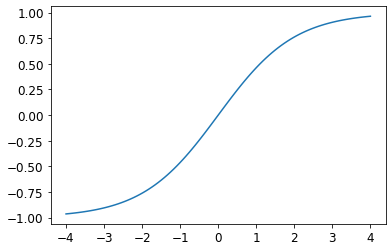

In [51]:

plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [52]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=7.585775847473997e-07)

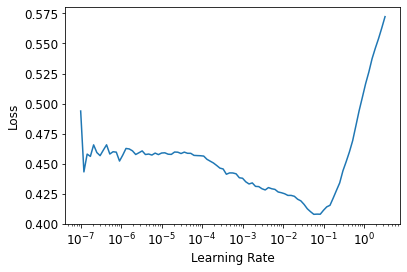

In [53]:
learn.lr_find()

We'll try an LR of 2e-2:

In [54]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.045654,0.014837,01:00


epoch,train_loss,valid_loss,time
0,0.008717,0.013997,01:30
1,0.003322,0.000368,01:32
2,0.001485,0.000321,01:34


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [55]:
math.sqrt(0.0001)

0.01

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

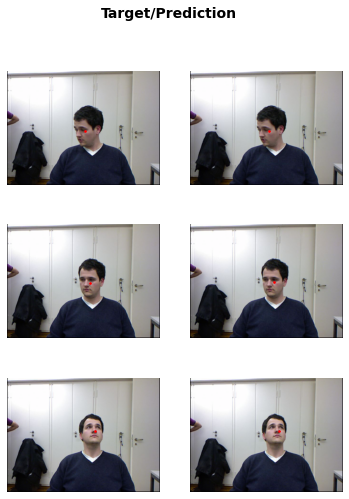

In [55]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))